In [1]:
import numpy as np
import lasagne
import matplotlib.pyplot as plt
from fwrf.models import *
from fwrf.utils import *
from fwrf.utils import make_rf_table
from scipy.stats.stats import pearsonr

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN not available)


In [2]:
%matplotlib inline

### Set up a fwrf with white noise training/val data

In [3]:
Ttrn,Tval,D,V,nmaps = 2040,301,17,4,8
deg_per_stim = 20
sf = 10

##feature maps
trn_feature_map_dict = {}
for ii in range(1,nmaps+1):
    input_name = 'fmap_%0.2d' % (ii)
    trn_feature_map_dict[input_name] = np.random.random((Ttrn,D,sf*ii,sf*ii)).astype('float32')

val_feature_map_dict = {}
for ii in range(1,nmaps+1):
    input_name = 'fmap_%0.2d' % (ii)
    val_feature_map_dict[input_name] = np.random.random((Tval,D,sf*ii,sf*ii)).astype('float32')

test_feature_map_dict = {}
for ii in range(1,nmaps+1):
    input_name = 'fmap_%0.2d' % (ii)
    test_feature_map_dict[input_name] = np.random.random((Tval,D,sf*ii,sf*ii)).astype('float32')
    

##true rfs
bound = int((deg_per_stim-3)/2.)
true_rfs = {k:np.random.randint(-bound,high=bound, size=V).astype('float32') for k in ['x0','y0']}
true_rfs['sig'] = np.random.randint(1,high=bound,size=V).astype('float32')

##random rfs
rand_rfs = {k:np.random.randint(-bound,high=bound, size=V).astype('float32') for k in ['x0','y0']}
rand_rfs['sig'] = np.random.randint(1,high=bound,size=V).astype('float32')


##true feature weights
true_NU = np.random.random((D*nmaps,V)).astype('float32')

#random feature weights
rand_NU = np.random.random((D*nmaps,V)).astype('float32')

##fwrf model
true_model = fwrf(val_feature_map_dict,deg_per_stim,V,rf_init=true_rfs, NU=true_NU)
true_model.normalize(lambda: (yield trn_feature_map_dict))

##true outputs, trn/val
trn_voxel_activity = true_model.predict(trn_feature_map_dict).astype('float32')
val_voxel_activity = true_model.predict(val_feature_map_dict).astype('float32')
test_voxel_activity = true_model.predict(test_feature_map_dict).astype('float32')

##data generator: note these are functions that *return* generators, so we can reboot the generator whenever.
trn_batch_size = 100
val_batch_size = Tval
trn_data_gen = lambda: (({k:v[ii:ii+trn_batch_size,:,:,:] for k,v in trn_feature_map_dict.iteritems()}, trn_voxel_activity[ii:ii+trn_batch_size,:]) for ii in range(0,Ttrn,trn_batch_size))
val_data_gen = lambda: (({k:v[ii:ii+val_batch_size,:,:,:] for k,v in val_feature_map_dict.iteritems()}, val_voxel_activity[ii:ii+val_batch_size,:]) for ii in range(0,Tval,val_batch_size))       

In [37]:
##rf grid for coarse training
deg_per_radius = (bound/2.,bound/2.,1)
spacing = 8
rf_grid_df = make_rf_table(deg_per_stim,deg_per_radius,spacing,pix_per_stim = None)

rf_grid = {}
# rf_grid['x0'] = rf_grid_df.x_deg.values.astype('float32')
# rf_grid['y0'] = rf_grid_df.y_deg.values.astype('float32')
# rf_grid['sig'] = rf_grid_df.deg_per_radius.values.astype('float32')
# print G
rf_grid['x0'] = np.array([0],dtype='float32')
rf_grid['y0'] = np.array([0],dtype='float32')
rf_grid['sig'] = np.array([4], dtype='float32')

G = rf_grid['x0'].shape[0]
print G

1


### Coarse vs. fine training (deterministic gradient descent)

####  coarse only

In [38]:
coarse_model = fwrf(val_feature_map_dict,deg_per_stim,V,rf_init=rand_rfs, NU=rand_NU)

In [39]:

true_rf_pics = true_model.rf_layer.make_rf_stack()

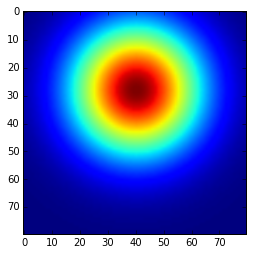

In [41]:

plt.imshow(true_rf_pics[3])


In [42]:
# coarse_model.normalize(lambda: (yield trn_feature_map_dict))
_=coarse_model.train_me(trn_data_gen, val_data_gen,
                        coarse=True,
                        rf_grid=rf_grid,
                        learning_rate=10e-6,
                        epochs=1,
                        num_iters = 15,
                        check_every=1,
                        print_stuff=True,
                        check_dims=False,
                        normalize=True,
                        consolidate=True)

will solve for: [feature_weights]
will update wrt: [feature_weights]
compiling...
=======epoch: 0
====iter: 0
number of improved models: 4
trn error: 333880.187500
====iter: 1
number of improved models: 4
trn error: 323104.281250
====iter: 2
number of improved models: 4
trn error: 313333.125000
====iter: 3
number of improved models: 4
trn error: 304469.000000
====iter: 4
number of improved models: 4
trn error: 296424.000000
====iter: 5
number of improved models: 4
trn error: 289119.000000
====iter: 6
number of improved models: 4
trn error: 282482.875000
====iter: 7
number of improved models: 4
trn error: 276451.562500
====iter: 8
number of improved models: 4
trn error: 270967.343750
====iter: 9
number of improved models: 4
trn error: 265978.187500
====iter: 10
number of improved models: 4
trn error: 261437.328125
====iter: 11
number of improved models: 3
trn error: 257302.468750
====iter: 12
number of improved models: 3
trn error: 253535.515625
====iter: 13
number of improved models: 3

In [43]:
# print get_model_params_names(coarse_model.fwrf)
# get_named_params(coarse_model.fwrf, 'rf_fmap_08.sig')['rf_fmap_08.sig'].get_value()
print get_model_params_names(coarse_model.fwrf)
get_named_params(coarse_model.fwrf, 'rf_fmap_08.sig')['rf_fmap_08.sig'].get_value()

['rf_fmap_08.x0', 'rf_fmap_08.y0', 'rf_fmap_08.sig', 'feature_weights']


array([ 4.,  4.,  4.,  4.], dtype=float32)

In [44]:
coarse_model.normalize(lambda: (yield trn_feature_map_dict))
test_pred_activity = coarse_model.predict(test_feature_map_dict)

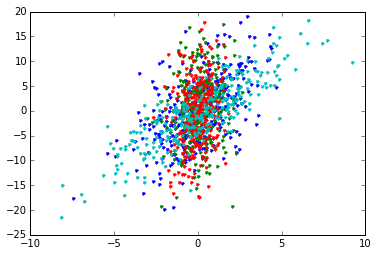

In [45]:
plt.plot(test_pred_activity, test_voxel_activity,'.')
# plt.axis('equal')

#### now try fine-tuning the coarse model

In [75]:
_=coarse_model.train_me(trn_data_gen, val_data_gen,
                        fine=True,
                        learning_rate=10e-6,
                        epochs=50,
                        learn_these_params = ['rf_fmap_08.x0', 'rf_fmap_08.y0'],
                        num_iters = 1,
                        check_every=1,
                        print_stuff=True,
                        check_dims=False)

will solve for: [rf_fmap_08.x0, rf_fmap_08.y0]
will update wrt: [rf_fmap_08.x0, rf_fmap_08.y0]
compiling...
=======epoch: 0
====iter: 0
number of improved models: 2
trn error: 12224.025391
====iter: 0
number of improved models: 3
trn error: 11836.213867
====iter: 0
number of improved models: 1
trn error: 11590.822266
====iter: 0
number of improved models: 0
trn error: 10388.914062
====iter: 0
number of improved models: 0
trn error: 11206.054688
====iter: 0
number of improved models: 0
trn error: 10731.265625
====iter: 0
number of improved models: 0
trn error: 10377.380859
====iter: 0
number of improved models: 0
trn error: 12066.984375
====iter: 0
number of improved models: 0
trn error: 11869.515625
====iter: 0
number of improved models: 0
trn error: 12074.873047
====iter: 0
number of improved models: 0
trn error: 12293.374023
====iter: 0
number of improved models: 0
trn error: 11944.695312
====iter: 0
number of improved models: 0
trn error: 10707.089844
====iter: 0
number of improved 

In [70]:
print '======================================'
_=coarse_model.train_me(trn_data_gen, val_data_gen,
                        fine=True,
                        learning_rate=10e-7,
                        epochs=15,
                        learn_these_params = ['feature_weights'],
                        num_iters = 1,
                        check_every=1,
                        print_stuff=True,
                        check_dims=False)

will solve for: [feature_weights]
will update wrt: [feature_weights]
compiling...
=======epoch: 0
====iter: 0
number of improved models: 2
trn error: 12425.220703
====iter: 0
number of improved models: 3
trn error: 12058.984375
====iter: 0
number of improved models: 3
trn error: 11756.491211
====iter: 0
number of improved models: 4
trn error: 10584.739258
====iter: 0
number of improved models: 2
trn error: 11408.882812
====iter: 0
number of improved models: 2
trn error: 10968.134766
====iter: 0
number of improved models: 2
trn error: 10561.162109
====iter: 0
number of improved models: 2
trn error: 12325.934570
====iter: 0
number of improved models: 2
trn error: 12135.325195
====iter: 0
number of improved models: 4
trn error: 12403.789062
====iter: 0
number of improved models: 4
trn error: 12481.443359
====iter: 0
number of improved models: 3
trn error: 12076.484375
====iter: 0
number of improved models: 2
trn error: 10905.062500
====iter: 0
number of improved models: 2
trn error: 11175

In [77]:
print get_model_params_names(coarse_model.rf_layer)
get_named_params(coarse_model.rf_layer, 'rf_fmap_08.x0')['rf_fmap_08.x0'].get_value()

['rf_fmap_08.x0', 'rf_fmap_08.y0', 'rf_fmap_08.sig']


array([ 0.01038229,  0.01139854,  0.20830892, -0.15675388], dtype=float32)

In [72]:
fine_test_pred_activity = coarse_model.predict(test_feature_map_dict)

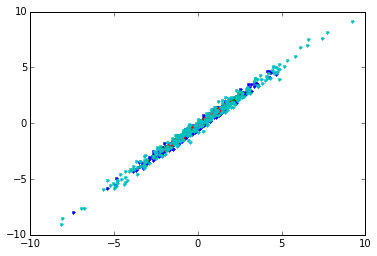

In [73]:
plt.plot(test_pred_activity, fine_test_pred_activity,'.')
# plt.axis('equal')

In [57]:
pearsonr(test_pred_activity.ravel(), test_voxel_activity.ravel())

(0.51300758, 8.6320840376893752e-82)

In [74]:
pearsonr(fine_test_pred_activity.ravel(), test_voxel_activity.ravel())

(0.54471248, 5.6500450683634315e-94)

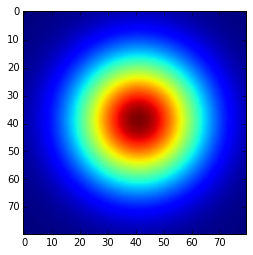

In [80]:
coarse_rf_pics = coarse_model.rf_layer.make_rf_stack()
plt.imshow(coarse_rf_pics[2])

### current conclusion:
under a variety of ways of trying fine-tuning, it doesn't seem to help very much or really at all. I can't get it to do anything useful.